In [8]:
import os
import random
import cv2
import numpy as np

from regions.selectivesearch_answer import selective_search
# from regions.selectivesearch import selective_search

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from chainercv.links import FeaturePredictor
from chainercv.links import VGG16

%matplotlib inline 

In [35]:
# DIRECTORY
DIR = '/data/unagi0/ilsvrc2017/ILSVRC/'

# GPU (-1 if performing on CPU)
GPU = -1

# IMAGE SELECTION PARAMETERS
RANDOM_SEED = 200
NUMBER_OF_IMAGES = 1

# SELECTIVE-SEARCH PARAMETERS
SCALE = 250
SIGMA = 0.9
MIN_SIZE = 50
MIN_REGION = 2000
MAX_WIDTH_HEIGHT_RATIO = 1.2


In [15]:
# Get image filenames from val.txt image set
with open(os.path.join(DIR, 'ImageSets/DET/val.txt')) as f:
    dataset = list(map(lambda f: f.strip().split()[0], f.readlines()))

# Sample random images from dataset
random.seed(RANDOM_SEED)
sample = random.sample(range(len(dataset)), NUMBER_OF_IMAGES)
image_paths = [os.path.join(DIR, 'Data/DET/val', dataset[i] + '.JPEG') for i in sample]

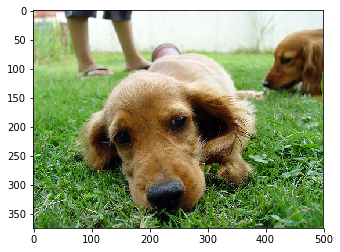

In [36]:
# Load and Display images
imgs = list()
for img_file in image_paths:
    img = mpimg.imread(img_file)
    imgs.append(img)
    plt.figure()
    plt.imshow(img)

38
CPU times: user 3.15 s, sys: 48 ms, total: 3.2 s
Wall time: 3.22 s


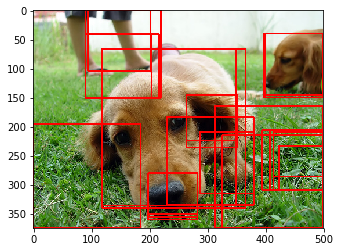

In [37]:
%%time
# Perform selective search on each image

cropped_regions = list()
for i, img in enumerate(imgs):
    img_lbl, regions = selective_search(img, scale=SCALE, sigma=SIGMA, min_size=MIN_SIZE)
    
    cropped_regions.append(list())
    for region in regions:
        if region['size'] < MIN_REGION:
            continue
            
        x, y, w, h = region['rect']
        
        if w / h > MAX_WIDTH_HEIGHT_RATIO or h / w > MAX_WIDTH_HEIGHT_RATIO:
            continue
        
        # axis order and data type changed in preparation for input
        # into CNN model
        cropped_regions[i].append(np.moveaxis(img[y:y+h,x:x+w,:],2,0).astype(np.float32))
        
        # uncomment lines below this for visualizing region proposals
        cv2.rectangle(img, (x, y), (x+w, y+h), 0xFF3333, thickness=2) 
    print(len(cropped_regions[i]))   
    plt.figure()
    plt.imshow(img)

In [38]:
# Initialize VGG16 classifier model
extractor = VGG16(1000, 'imagenet')
model = FeaturePredictor(extractor, crop_size=224, scale_size=256, crop='center')

In [39]:
if GPU >= 0:
    chainer.cuda.get_device(GPU).use()
    model.to_gpu()
prob = model.predict(cropped_regions[0])

In [40]:
prob

array([[  4.35770698e-06,   1.46425209e-05,   1.52523924e-07, ...,
          7.84972087e-07,   1.64546873e-04,   6.38523261e-06],
       [  1.16150284e-06,   2.96049097e-06,   4.97264878e-08, ...,
          1.68449139e-06,   1.36728690e-04,   8.18373665e-05],
       [  2.78202970e-06,   2.49692839e-05,   1.71029228e-07, ...,
          4.89877993e-06,   9.80699260e-05,   9.59604859e-06],
       ..., 
       [  3.91668955e-08,   3.66545017e-08,   7.64955175e-08, ...,
          3.56751997e-08,   1.45215392e-06,   2.10899525e-05],
       [  1.09935138e-06,   3.11122631e-06,   4.04354523e-08, ...,
          3.56917354e-07,   4.56056114e-05,   2.66319375e-06],
       [  9.57594821e-05,   8.19790876e-05,   2.15498185e-05, ...,
          1.01276664e-05,   2.79399945e-04,   1.51041313e-03]], dtype=float32)